In [1]:
import networkx as nx
%load_ext autoreload
%autoreload 2

In [24]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import networkx as nx

In [4]:
plt.rcParams["figure.figsize"] = (20,3)

In [54]:
from shared.constants import DatasetPath
from datasets.schema import DatasetSchema
from datasets.loading import load_igraph, igraph_to_nx

from datasets.visualization import plot_explore_dual_histogram, show_top_k_nodes

In [2]:
DATASET = DatasetPath('social-distancing-student')
schema = DatasetSchema.load_schema(DATASET.name)
G = load_igraph(schema)

# Dataset Specific Statistics

## Visualize Distribution of Nodes over Time

In [5]:
df_tweets = schema.get_node_schema('Tweet').load_df()

Text(0, 0.5, 'Number of Tweets')

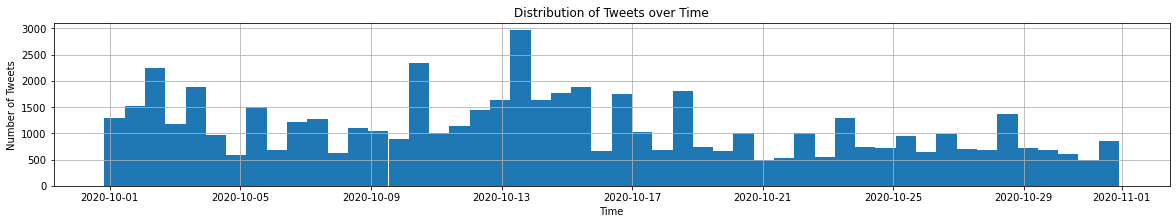

In [6]:
df_tweets['created_at'].hist(
    bins=50,
)
plt.title('Distribution of Tweets over Time')
plt.xlabel('Time')
plt.ylabel('Number of Tweets')

# Global Statistics

In [7]:
print(f'Number of Nodes: {G.vcount()}')
print(f'Number of Edges: {G.ecount()}')
print(f'Density: {G.density()}')

Number of Nodes: 93433
Number of Edges: 3710183
Density: 0.0008500204765102186


In [8]:
degrees = pd.Series(G.degree())

In [9]:
print(f'Average Degree: {np.mean(degrees)}')
print(f'Median Degree: {np.median(degrees)}')

Average Degree: 79.41911316130275
Median Degree: 4.0


Text(0, 0.5, 'Number of Nodes')

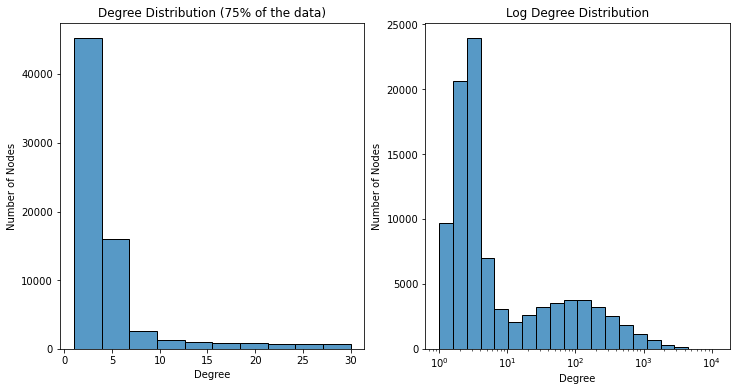

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12,6))

quantile = 0.75
data = degrees[degrees < degrees.quantile(quantile)]
ax = sns.histplot(
    data=data,
    bins=max(1, min(10, len(data.value_counts()))),
    ax=axes[0],
)
ax.set_title('Degree Distribution ({}% of the data)'.format(int(quantile*100)))
ax.set_xlabel('Degree')
ax.set_ylabel('Number of Nodes')

data = degrees
ax = sns.histplot(
    data=data,
    bins=max(1, min(20, len(data.value_counts()))),
    log_scale=True,
    ax=axes[1],
)
ax.set_title('Log Degree Distribution')
ax.set_xlabel('Degree')
ax.set_ylabel('Number of Nodes')

In [11]:
k = 10
top_k = degrees.sort_values(ascending=False).head(k).index
print(f'Top {k} Degree Nodes')
df_tmp = pd.DataFrame([
    {
        'degree': degrees[i],
        'label': G.vs[i]['label'],
    }
    for i in top_k
])
df_tmp.head(k)

Top 10 Degree Nodes


,degree,label
0,11505,NOS
1,11073,Mark Rutte
2,7711,RIVM
3,7670,Matthijs Pontier 💜🏴‍☠️
4,7456,NU.nl
5,7108,de Volkskrant
6,7056,RTL Nieuws
7,6988,Thierry Baudet
8,6845,Wierd Duk
9,6563,Maurice de Hond


## Connectivity Metrics
* **degree_centrality**: Degree centrality of a node is the fraction of nodes it is connected to.
* **closeness_centrality**: Closeness centrality of a node is the inverse of the average shortest path length to all other nodes.
* **betweenness_centrality**: Betweenness centrality of a node is the fraction of all shortest paths in the network that pass through it.
* **eigenvector_centrality**: Eigenvector centrality of a node is the normalized sum of the eigenvector centralities of all its neighbors.
* **pagerank**: PageRank is a ranking of nodes based on the structure of the network.
* **transitivity**: Clustering coefficient is the fraction of triangles that are formed by a node and its neighbors.

In [81]:
# Use the largest connected component
G_cc = G.clusters().giant()

# Convert to NetworkX
nx_G = igraph_to_nx(G_cc)
nx_Gu = nx.Graph(nx_G)

In [82]:
print('Average Clustering Coefficient: {}'.format(nx.approximation.average_clustering(nx_Gu)))
print('Diameter: {}'.format(nx.approximation.diameter(nx_Gu)))

Average Clustering Coefficient: 0.29
Diameter: 15


In [83]:
# Calculate the metrics
degree_centrality = nx.degree_centrality(nx_G)
betweenness_centrality = nx.betweenness_centrality(nx_Gu, k=5)
eigenvector_centrality = nx.eigenvector_centrality(nx_Gu)
page_rank = nx.pagerank(nx_Gu)
transitivity = dict(zip(G_cc.vs['name'], G_cc.transitivity_local_undirected()))

In [87]:
node_stats = pd.DataFrame({
    'degree_centrality': degree_centrality,
    'betweenness_centrality': betweenness_centrality,
    'eigenvector_centrality': eigenvector_centrality,
    'page_rank': page_rank,
    'transitivity': transitivity
})
node_stats.describe()

,degree_centrality,betweenness_centrality,eigenvector_centrality,page_rank,transitivity
count,92828.000000,9.282800e+04,9.282800e+04,92828.000000,82458.000000
mean,0.000861,2.794663e-05,9.327505e-04,0.000011,0.338164
std,0.003063,1.162308e-03,3.146855e-03,0.000031,0.352957
min,0.000011,0.000000e+00,2.292513e-21,0.000002,0.000000
25%,0.000022,0.000000e+00,4.537200e-06,0.000002,0.000000
50%,0.000043,6.043748e-09,3.081323e-05,0.000004,0.234477
75%,0.000345,5.944338e-06,3.225603e-04,0.000008,0.499552
max,0.123940,1.942476e-01,6.207933e-02,0.002366,1.000000


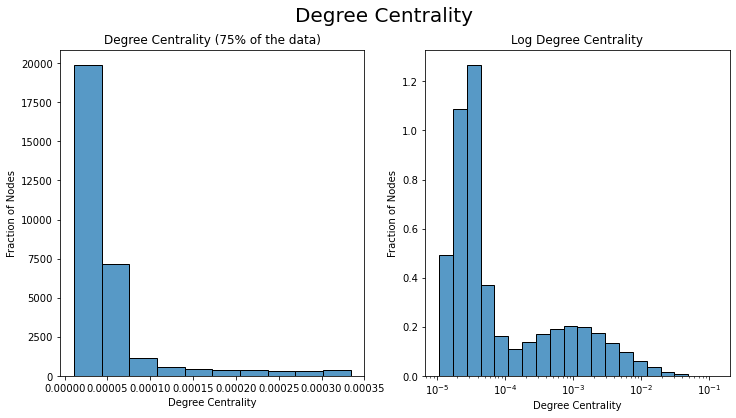

/dd_volume/Development/Python/Thesis/code/env/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Failed to plot Betweenness Centrality


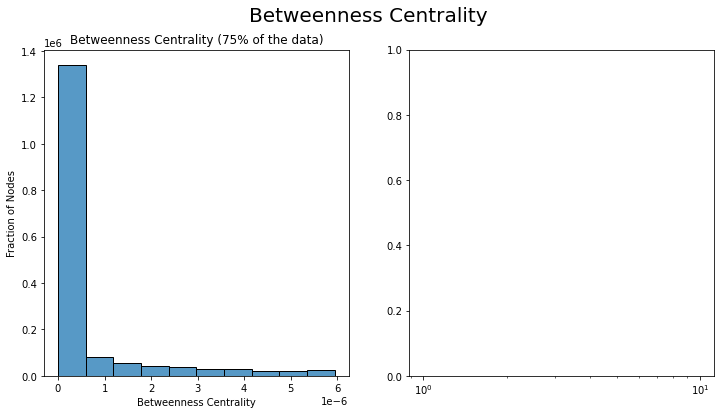

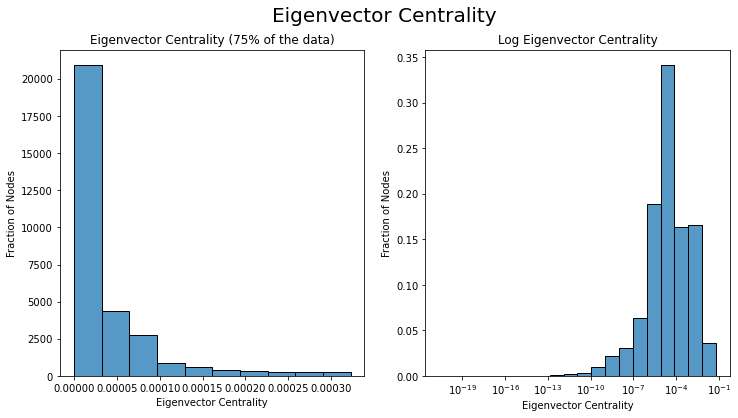

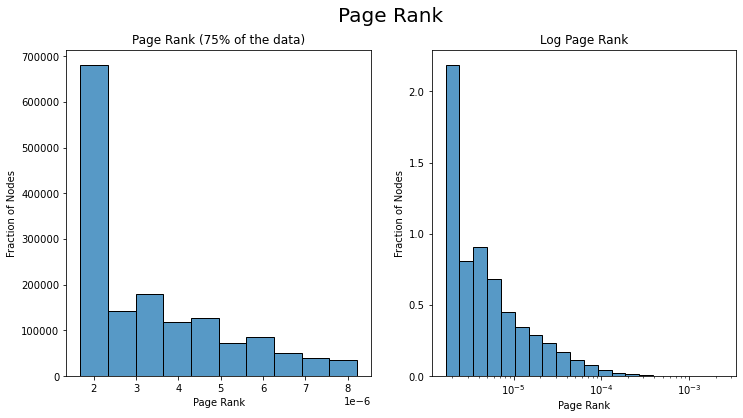

/dd_volume/Development/Python/Thesis/code/env/lib/python3.9/site-packages/pandas/core/arraylike.py:364: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


Failed to plot Transitivity


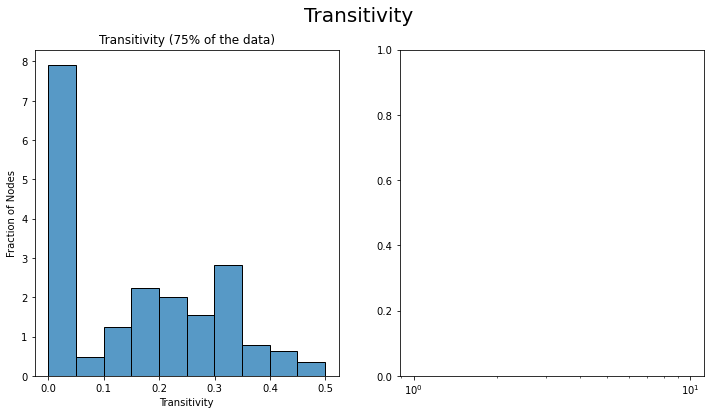

In [85]:
for col in node_stats.columns:
    title = col.replace('_', ' ').title()
    data = node_stats[col][np.isfinite(node_stats[col])]
    try:
        plot_explore_dual_histogram(
            series=data,
            title=title,
            title_short=title,
            xlabel=title,
            ylabel='Fraction of Nodes',
            normalize=True,
        )
        plt.show()
    except:
        print(f'Failed to plot {title}')

In [91]:
labels = dict(zip(G_cc.vs['name'], G_cc.vs['label']))

for col in node_stats.columns:
    title = col.replace('_', ' ').title()
    data = node_stats[col][np.isfinite(node_stats[col])]
    show_top_k_nodes(
        data,
        labels,
        title=title,
    )

Top 10 Degree Centrality
      value                   label
0  0.123940                     NOS
1  0.119286              Mark Rutte
2  0.083069                    RIVM
3  0.082627  Matthijs Pontier 💜🏴‍☠️
4  0.080321                   NU.nl
5  0.076573           de Volkskrant
6  0.076012              RTL Nieuws
7  0.075280          Thierry Baudet
8  0.073739               Wierd Duk
9  0.070701         Maurice de Hond
Top 10 Betweenness Centrality
      value                                              label
0  0.194248                                        Dick Kraaij
1  0.186472                                         Mark Rutte
2  0.105928  RT @kroon125: Is nederland de volgende @MinPre...
3  0.096049         Patrícia 🇳🇱 🇧🇷 #ForaBolsonaro #BreekDeGolf
4  0.094099  Is nederland de volgende @MinPres❓#Corona #Cov...
5  0.078836                                    Nancy Bastiaans
6  0.062740                                          Arie Slob
7  0.061452                                  

## Connected Components Statistics

In [16]:
print(f'Number of Connected Components: {len(G.components())}')
largest_cc = G.components().giant()
print(f'Size of the largest component: {largest_cc.vcount()}')
# print('Diameter of the largest component: {}'.format(largest_cc.diameter()))

Number of Connected Components: 245
Size of the largest component: 92828


Text(0.5, 1.0, 'Connected Components')

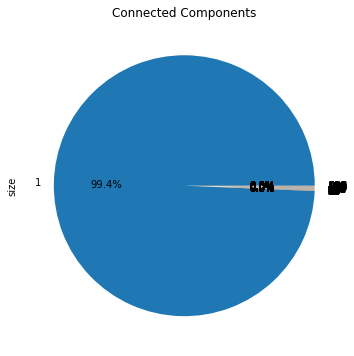

In [17]:
df_tmp = pd.DataFrame([{'size': len(c)} for i,c in enumerate(G.components())], index=range(1,len(G.components())+1))
ax = df_tmp.plot.pie(
    y='size',
    figsize=(6,6),
    autopct='%1.1f%%',
    legend=False,
)
ax.set_title('Connected Components')

# Type Specific Statistics

### Node Type Statistics

In [51]:
node_types = schema.get_node_types()
node_type_stats = pd.DataFrame([
    {
        'type': node_type,
        'count': len(G.vs.select(type=node_type)),
        'degree_avg': np.mean(G.vs.select(type=node_type).degree()),
        'degree_median': np.median(G.vs.select(type=node_type).degree()),
    }
    for node_type in node_types
], index=node_types)
print('Node Type count: {}'.format(len(node_types)))
node_type_stats

Node Type count: 3


,type,count,degree_avg,degree_median
User,User,34919,207.401501,69.0
Hashtag,Hashtag,2341,5.259718,1.0
Tweet,Tweet,56173,2.951596,3.0


<AxesSubplot:title={'center':'Node type counts'}, ylabel='count'>

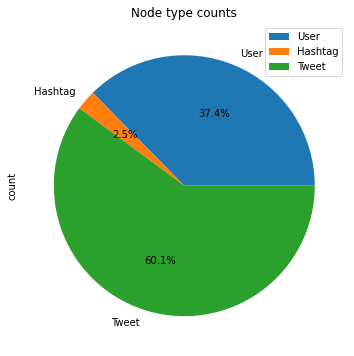

In [52]:
node_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Node type counts', figsize=(6,6))

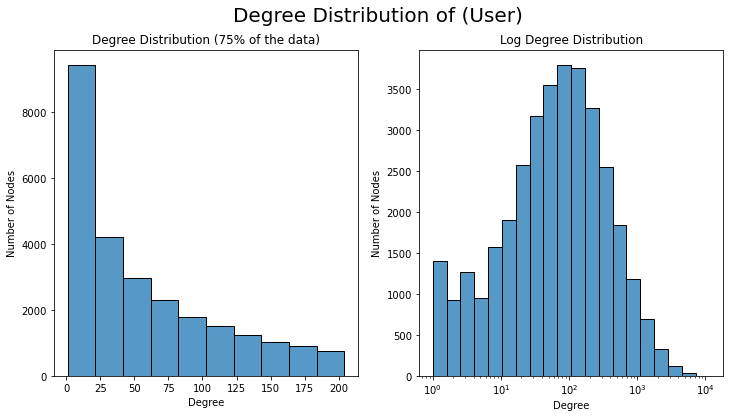

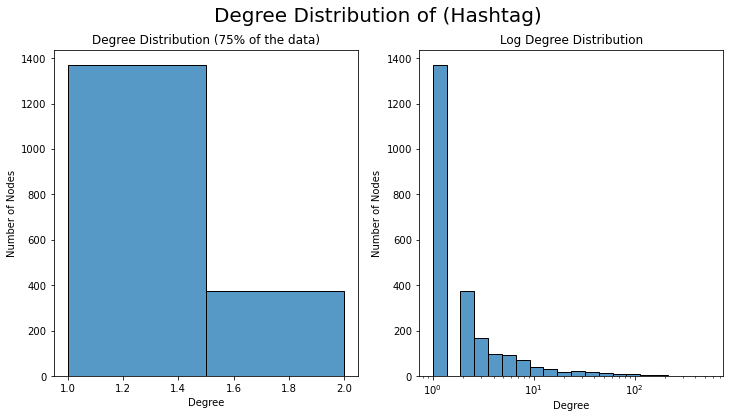

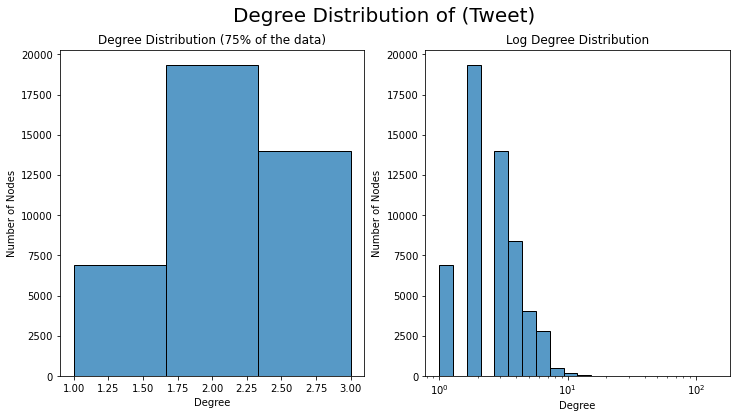

In [55]:
for node_type in node_types:
    degrees = pd.Series(G.vs.select(type=node_type).degree())
    plot_explore_dual_histogram(
        series=degrees,
        title=f'Degree Distribution of ({node_type})',
        title_short='Degree Distribution',
        xlabel='Degree',
        ylabel='Number of Nodes',
    )
    plt.show()

In [97]:
for node_type in node_types:
    nodes = G.vs.select(type=node_type)
    data = pd.Series(nodes.degree(), index=nodes['name'])
    labels = dict(zip(nodes['name'], nodes['label']))
    show_top_k_nodes(
        data,
        labels,
        title=f'Degree Nodes of Type ({node_type})'
    )

Top 10 Degree Nodes of Type (User)


,value,label
0,11505,NOS
1,11073,Mark Rutte
2,7711,RIVM
3,7670,Matthijs Pontier 💜🏴‍☠️
4,7456,NU.nl
5,7108,de Volkskrant
6,7056,RTL Nieuws
7,6988,Thierry Baudet
8,6845,Wierd Duk
9,6563,Maurice de Hond


Top 10 Degree Nodes of Type (Hashtag)


,value,label
0,552,anderhalvemeter
1,413,coronamaatregelen
2,389,mondkapjes
3,340,mondkapje
4,279,coroNEE
5,223,coronavirus
6,208,Covid19
7,193,anderhalvemeterdictatuur
8,178,corona
9,150,Corona


Top 10 Degree Nodes of Type (Tweet)


,value,label
0,143,"@vanbinnenblauw @lisette1100 Hoi, het is belan..."
1,59,"Volgens collega Wilders is de 1,5 meter-regel ..."
2,34,"HOUD 1,5 METER AFSTAND. WAS JE HANDEN STUK. LA..."
3,29,#JAGERS #KRIMPENERWAARD OVERTREDEN #CORONA REG...
4,28,Houden ons aan de regels zoals deze vandaag ge...
5,22,"""de coronamaatregelen zijn strikt nageleefd. [..."
6,21,Draag een mondkapje in publiek toegankelijke b...
7,21,RedTeam luidt alarmbellen: ’Leerlingen voortge...
8,16,"Mijn oom heeft corona en is besmettelijk, maar..."
9,16,"@peter_persyn @De7deDag Beste, bedankt voor de..."


### Edge Type Statistics

In [32]:
edge_types = schema.get_edge_types()
edge_type_stats = pd.DataFrame([
    {
        'type': edge_type,
        'count': len(G.es.select(type=edge_type)),
    }
    for edge_type in edge_types
], index=edge_types)
print('Edge Type count: {}'.format(len(edge_types)))
edge_type_stats

Edge Type count: 7


,type,count
TWEETED,TWEETED,56173
REPLIES_TO_USER,REPLIES_TO_USER,21769
REPLIES_TO_TWEET,REPLIES_TO_TWEET,2148
QUOTES_TWEET,QUOTES_TWEET,441
MENTIONS_USER,MENTIONS_USER,70367
MENTIONS_HASHTAG,MENTIONS_HASHTAG,12313
FOLLOWS,FOLLOWS,3546972


<AxesSubplot:title={'center':'Edge type counts'}, ylabel='count'>

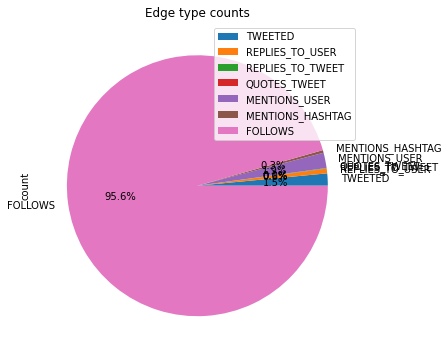

In [41]:
edge_type_stats.plot.pie(y='count', autopct='%1.1f%%', title='Edge type counts', figsize=(6,6))